In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time

from bumps.names import *
from bumps.fitters import fit

import sasmodels

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data, empty_data1D
from sasmodels.direct_model import DirectModel

import bumps

# uncomment and replace correct path if required for importing the sasview package
#sys.path.append('/path/to/sasview/src')
import sas

import multiprocessing as mp

In [2]:
# sample meta-data
sample_info = pd.read_csv('../../data/sans/Sample_Info.csv')

# helpful meta-data dictionaries
names = dict(zip(sample_info['Sample'], sample_info['Name']))
cps = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer']))
matrix = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer']))
solvent_names = dict(zip(sample_info['Sample'], sample_info['Solvent']))

# target weight percents of conjugated polymer
target = dict(zip(sample_info['Sample'], sample_info['Target Fraction']*100))

# fixing 401/402 and 403/404 sample pair target values for plotting colors only
target[401] = 0.5
target[402] = 0.1
target[403] = 5
target[404] = 1

# actual volume percentages
data = np.loadtxt('../../data/uv_vis/Corrected_wtPercents.csv', delimiter=',', skiprows=1)
actual_vol = {}
actual_stdev_vol = {}
for key, tar, act, stdev, act_vol, stdev_vol in data:
    actual_vol[key] = act_vol
    actual_stdev_vol[key] = stdev_vol
    
slds = {'RRe-P3HT':0.676,
       'RRa-P3HT':0.676,
       'P3DDT':0.316,
       'PQT-12':0.676,
       #'Polystyrene-D8':6.407,
       'Polystyrene-D8':6.464, # density of 1.13 g/mL
       'Polystyrene-H8':1.426}

data_dir = '../../data/sans/Smeared_Data_20200629/'
files = os.listdir(data_dir)
sans_data = {}
usans_data = {}
for file in files:
    if 'USANS' in file:
        key = int(file.split('_')[0][3:])
        usans_data[key] = load_data(data_dir + file)
    elif 'SANS' in file:
        key = int(file.split('_')[0][3:])
        sans_data[key] = load_data(data_dir + file)
        
true_keys = []

true_reads = pd.read_csv('../../data/sans/Fit_Truths.csv')
true_reads = true_reads.to_numpy()
mask = true_reads[:,4].astype(bool)

ellipsoid_parallel_keys = true_reads[mask,0]

run_keys = list(ellipsoid_parallel_keys)

background_files = [file for file in os.listdir('../../data/sans/PS_Fitting/ps_fit_results/power_law_background') if 'json' in file]
backgrounds = {} # key is sample key, value is ('best', '95% confidence interval')
for file in background_files:
    data_read = pd.read_json('../../data/sans/PS_Fitting/ps_fit_results/power_law_background/' + file)
    key = int(file.split('_')[0][3:])
    p95 = data_read.loc['p95',str(key) + ' background']
    backgrounds[key] = (data_read.loc['best',str(key) + ' background'], p95)
    
power_law_fit_info = pd.read_json('../../data/sans/PS_Fitting/ps_fit_results/power_law_porod_exp_scale/PS_porod_exp_scale-err.json')
ps_scales = {}

for key, value in power_law_fit_info.items():
    if 'porod_exp' in key:
        ps_porod_exp = value['best']
        ps_porod_exp_95 = value['p95']
    else:
        key = int(key.split()[0])
        ps_scales[key] = (value['best'], value['p95'])
        
guinier_porod_fit = pd.read_json('../../data/sans/PS_Fitting/ps_fit_results/guinier_porod_s_scale/PS_s_scale-err.json')
rgs = {}
adjusted_scales = {}
for key, value in guinier_porod_fit.items():
    if key == 'ps s':
        ps_s = value['best']
        ps_s_95 = value['p95']
    elif 'rg' in key:
        key = int(key.split()[0])
        rgs[key] = (value['best'], value['p95'])
    elif 'scale' in key:
        key = int(key.split()[0])
        ps_scales[key] = (value['best'], value['p95'])
        
for key in rgs.keys():
    q1 = (1/rgs[key][0]) * np.sqrt((ps_porod_exp - ps_s)*(3-ps_s)/2)
    new_scale = ps_scales[key][0] * np.exp(-1*q1**2*rgs[key][0]**2/(3-ps_s)) * q1**(ps_porod_exp - ps_s)
    new_95p = np.array(ps_scales[key][1]) * np.exp(-1*q1**2*rgs[key][0]**2/(3-ps_s)) * q1**(ps_porod_exp - ps_s)
    adjusted_scales[key] = (new_scale, list(new_95p))

    
avg_rg = np.average([x[0] for x in rgs.values()])
max_rg = np.max([x[1][1] for x in rgs.values()])
min_rg = np.min([x[1][0] for x in rgs.values()])

avg_scale = np.average([x[0] for y, x in ps_scales.items() if y in rgs.keys()])
max_scale = np.average([x[1][1] for y, x in ps_scales.items() if y in rgs.keys()])
min_scale = np.average([x[1][0] for y, x in ps_scales.items() if y in rgs.keys()])

porod_files = [file for file in os.listdir('../../data/sans/Porod_analysis/porod_results') if 'json' in file]

for file in porod_files:
    data_read = pd.read_json('../../data/sans/Porod_analysis/porod_results/' + file)
    key = int(file.split('_')[0][3:])
    for column, value in data_read.items():
        if 'background' in column:
            backgrounds[key] = (value['best'], value['p95']) 
            
os.makedirs('../../data/sans/Sample_Fitting/fitting_results/ps_ellipsoid_cylinder_lm', exist_ok=True)
run_keys = [key for key in run_keys if key in actual_vol.keys() and key in usans_data.keys()]

In [8]:
def fit_function(
    key,
    sans_data,
    usans_data,
    actual_vol,
    actual_stdev_vol,
    backgrounds,
    avg_scale,
    avg_rg,
    ps_s,
    ps_porod_exp,
    slds,
    cps,
    matrix):

    #np.savetxt('Sample_'+str(key)+'.txt', np.array(['Fitting']), fmt='%s')
    kernel = load_model("guinier_porod+ellipsoid+cylinder")


    # loading the data
    sans = sans_data[key]
    sans.dx = sans.dx-sans.dx # removing smearing from sans segment
    usans = usans_data[key]

    vol = actual_vol[key]/100 # cp volume fraction from uv-vis
    vol_stdev = actual_stdev_vol[key]/100

    # initial parameter values

    scale = Parameter(1, name=str(key) + 'scale')
    background = Parameter(backgrounds[key][0], name=str(key) + 'background')

    A_scale = Parameter(avg_scale*(1-vol), name=str(key) + ' PS scale')
    A_rg = Parameter(avg_rg, name=str(key) + ' PS rg')
    A_s = Parameter(ps_s, name=str(key) + ' PS s')
    A_porod_exp = Parameter(ps_porod_exp, name=str(key) + ' PS porod_exp')

    scale_ratio = Parameter(0.8, name=str(key) + ' B scale ratio').range(0,1)
    scale_normal = bumps.bounds.Normal(mean=vol, std=vol_stdev)
    cp_scale = Parameter(vol*2, name=str(key) + ' cp scale', bounds=scale_normal)
    
    B_scale = scale_ratio * cp_scale

    B_sld = Parameter(slds[cps[key]], name=str(key) + ' PS sld')
    B_sld_solvent = Parameter(slds[matrix[key]], name=str(key) + ' PS solvent')

    B_radius_polar = Parameter(5000, limits=[0,inf], name=str(key) + ' ellipsoid polar radius').range(10,200000)
    B_radius_polar_pd = Parameter(0.5, name = str(key) + ' ellipsoid polar radius pd')
    B_radius_polar_pd_n = Parameter(200, name = str(key) + ' ellipsoid polar radius pd n')
    B_radius_polar_pd_nsigma = Parameter(8, name = str(key) + ' ellipsoid polar radius pd nsigma') 
    
    B_radius_equatorial = Parameter(10000, limits=[0,inf], name=str(key) + ' ellipsoid equatorial radius').range(100,200000)
    B_radius_equatorial_pd = Parameter(0.5, name = str(key) + ' ellipsoid equatorial radius pd')
    B_radius_equatorial_pd_n = Parameter(200, name = str(key) + ' ellipsoid equatorial radius pd n')
    B_radius_equatorial_pd_nsigma = Parameter(8, name = str(key) + ' ellipsoid equatorial radius pd nsigma') 
    
    C_scale = (1-scale_ratio) * cp_scale
    
    C_sld = Parameter(slds[cps[key]], name=str(key) + ' PS sld')
    C_sld_solvent = Parameter(slds[matrix[key]], name=str(key) + ' PS solvent')
        
    C_radius = Parameter(100, limits=[0,inf], name = str(key) + ' cylinder radius').range(10,1000)
    C_radius_pd  = Parameter(0.2, name = str(key) + ' cylinder radius pd')
    C_radius_pd_n = Parameter(200, name = str(key) + ' cylinder radius pd n')
    C_radius_pd_nsigma = Parameter(8, name = str(key) + ' cylinder radius pd nsigma')

    C_length = Parameter(120000, limits=[0,inf], name = str(key) + ' cylinder length').range(10000,300000)
    #C_length = Parameter(200000, limits=[0,inf], name = str(key) + ' length')
    C_length_pd  = Parameter(0, name = str(key) + ' length pd')
    C_length_pd_n = Parameter(200, name = str(key) + ' length pd n')
    C_length_pd_nsigma = Parameter(8, name = str(key) + ' length pd nsigma')
   

    # setting up the combined model for fitting
    sans_model = Model(
        model=kernel,
        scale=scale,
        background=background,
        A_scale=A_scale,
        A_rg=A_rg,
        A_s=A_s,
        A_porod_exp=A_porod_exp,
        B_scale=B_scale,
        B_sld=B_sld,
        B_sld_solvent=B_sld_solvent,
        B_radius_polar = B_radius_polar,
        B_radius_polar_pd_type = 'lognormal',
        B_radius_polar_pd = B_radius_polar_pd,
        B_radius_polar_pd_n = B_radius_polar_pd_n,
        B_radius_polar_pd_nsigma = B_radius_polar_pd_nsigma,
        B_radius_equatorial = B_radius_equatorial,
        B_radius_equatorial_pd_type = 'lognormal',
        B_radius_equatorial_pd = B_radius_equatorial_pd,
        B_radius_equatorial_pd_n = B_radius_equatorial_pd_n,
        B_radius_equatorial_pd_nsigma = B_radius_equatorial_pd_nsigma,
        C_scale = C_scale,
        C_sld = C_sld,
        C_sld_solvent = C_sld_solvent,
        C_radius = C_radius,
        C_radius_pd_type='lognormal',
        C_radius_pd = C_radius_pd,
        C_radius_pd_n = C_radius_pd_n,
        C_radius_pd_nsigma = C_radius_pd_nsigma,
        C_length = C_length,
        C_length_pd_type='lognormal',
        C_length_pd = C_length_pd,
        C_length_pd_n = C_length_pd_n,
        C_length_pd_nsigma = C_length_pd_nsigma,
    )

    # setting parameter ranges as needed

    sans_experiment=Experiment(data=sans, model=sans_model)
    usans_experiment=Experiment(data=usans, model=sans_model)

    usans_smearing = sasmodels.resolution.Slit1D(usans.x, 0.117)
    usans_experiment.resolution = usans_smearing

    experiment = [sans_experiment, usans_experiment]

    problem=FitProblem(experiment)
    
    result=fit(problem, method='lm', verbose=True)
    
    #result=fit(problem, method='dream', samples=1e6, verbose=True)
    #result.state.save('../data/sans/Sample_Fitting/fitting_results/ps_sphere_parrallelepiped/CMW' + str(key) + '_ps_sphere_parallelepiped_state')
    
    return(problem, result)


In [9]:
os.makedirs('../../data/sans/Sample_Fitting/fitting_results/ps_ellipsoid_cylinder_lm/',exist_ok=True)

#all_problems = {}

new_keys = run_keys[4:9]

#for key in new_keys:
for key in [405]:

    problem, result = fit_function(key, sans_data, usans_data, actual_vol, actual_stdev_vol, backgrounds, avg_scale, avg_rg, ps_s, ps_porod_exp, slds, cps, matrix)
    problem.plot()
#     all_problems[key] = (problem, result)

#     params = [str(key) + ' ellipsoid equatorial radius',str(key) + ' ellipsoid polar radius',str(key)+' cylinder length',str(key) + ' cylinder radius',str(key) + ' B scale ratio',str(key) + ' cp scale']
#     params = np.array(params)

#     save_results = result.x.astype(str)
#     save_results_dx = result.dx.astype(str)

#     np.savetxt('../../data/sans/Sample_Fitting/fitting_results/ps_ellipsoid_cylinder_lm/CMW' + str(key) + '_results.csv', np.vstack((params,save_results,save_results_dx)).T, delimiter=',', fmt='%s')


KeyboardInterrupt: 

In [13]:
os.makedirs('../../data/sans/Sample_Fitting/fitting_results/ps_ellipsoid_cylinder_lm/',exist_ok=True)

#all_problems = {}

new_keys = run_keys[4:9]

#for key in new_keys:
for key in [407]:
#for key in [104,105,111,112,304,305,403,404,405,408,504,505]:
#for key in [4,5,24,30,31,104,105,111,112,304,305,403,404,405,408,504,505]:

    problem, result = fit_function(key, sans_data, usans_data, actual_vol, actual_stdev_vol, backgrounds, avg_scale, avg_rg, ps_s, ps_porod_exp, slds, cps, matrix)
    #problem.plot()
    all_problems[key] = (problem, result)

    params = [str(key) + ' ellipsoid equatorial radius',str(key) + ' ellipsoid polar radius',str(key)+' cylinder length',str(key) + ' cylinder radius',str(key) + ' B scale ratio',str(key) + ' cp scale']
    params = np.array(params)

    save_results = result.x.astype(str)
    save_results_dx = result.dx.astype(str)

    np.savetxt('../../data/sans/Sample_Fitting/fitting_results/ps_ellipsoid_cylinder_lm/CMW' + str(key) + '_results.csv', np.vstack((params,save_results,save_results_dx)).T, delimiter=',', fmt='%s')


final chisq 6.986(30) constraints=510.084
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
         407 ellipsoid equatorial radius 11.78(19)e3     11776(71)      
              407 ellipsoid polar radius 100.0(27)       100.0(10)      
                     407 cylinder length 134.05(92)e3    134.05(35)e3   
                     407 cylinder radius 95.53(48)       95.53(18)      
                       407 B scale ratio 0.6890(55)      0.6890(21)     
                            407 cp scale 0.005438(76)    0.005438(29)   


In [24]:
os.makedirs('../../data/sans/Sample_Fitting/fitting_results/ps_ellipsoid_cylinder_lm/',exist_ok=True)

all_problems = {}

new_keys = run_keys[4:9]

#for key in new_keys:
for key in [104,105,111,112,304,305,403,404,405,408,504,505]:
#for key in [4,5,24,30,31,104,105,111,112,304,305,403,404,405,408,504,505]:

    problem, result = fit_function(key, sans_data, usans_data, actual_vol, actual_stdev_vol, backgrounds, avg_scale, avg_rg, ps_s, ps_porod_exp, slds, cps, matrix)
    #problem.plot()
    all_problems[key] = (problem, result)

    params = [str(key) + ' ellipsoid equatorial radius',str(key) + ' ellipsoid polar radius',str(key)+' cylinder length',str(key) + ' cylinder radius',str(key) + ' B scale ratio',str(key) + ' cp scale']
    params = np.array(params)

    save_results = result.x.astype(str)
    save_results_dx = result.dx.astype(str)

    np.savetxt('../../data/sans/Sample_Fitting/fitting_results/ps_ellipsoid_cylinder_lm/CMW' + str(key) + '_results.csv', np.vstack((params,save_results,save_results_dx)).T, delimiter=',', fmt='%s')


final chisq 100.573(30) constraints=87.8099
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
         104 ellipsoid equatorial radius 30.00(99)e3     29998(99)      
              104 ellipsoid polar radius 1478.0(99)      1477.99(99)    
                     104 cylinder length 115.22(31)e3    115224(31)     
                     104 cylinder radius 76.24(11)       76.243(11)     
                       104 B scale ratio 0.83569(91)     0.835686(90)   
                            104 cp scale 0.06572(32)     0.065725(32)   
final chisq 127.810(30) constraints=5.59072
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
         105 ellipsoid equatorial radius 32.3(11)e3      32342(95)      
              105 ellipsoid polar radius 1683(10)        1682.81(91)    
                     105 cylinder length 115.55(26)e3    115554(23)     
                     105 cylinder radius 76.295(85)      76.2955(75)    
                       105

In [165]:
def fit_function2(
    key,
    sans_data,
    usans_data,
    actual_vol,
    actual_stdev_vol,
    backgrounds,
    avg_scale,
    avg_rg,
    ps_s,
    ps_porod_exp,
    slds,
    cps,
    matrix):

    #np.savetxt('Sample_'+str(key)+'.txt', np.array(['Fitting']), fmt='%s')
    kernel = load_model("guinier_porod+ellipsoid+cylinder")


    # loading the data
    sans = sans_data[key]
    sans.dx = sans.dx-sans.dx # removing smearing from sans segment
    usans = usans_data[key]
    
    mask = np.where(usans.x>2e-4)
    
    usans = sasmodels.data.Data1D(x=usans.x[mask],y=usans.y[mask],dx=usans.dx[mask],dy=usans.dy[mask])

    vol = actual_vol[key]/100 # cp volume fraction from uv-vis
    vol_stdev = actual_stdev_vol[key]/100

    # initial parameter values

    scale = Parameter(1, name=str(key) + 'scale')
    background = Parameter(backgrounds[key][0], name=str(key) + 'background')

    A_scale = Parameter(avg_scale*(1-vol), name=str(key) + ' PS scale')
    A_rg = Parameter(avg_rg, name=str(key) + ' PS rg')
    A_s = Parameter(ps_s, name=str(key) + ' PS s')
    A_porod_exp = Parameter(ps_porod_exp, name=str(key) + ' PS porod_exp')

    scale_ratio = Parameter(0.85, name=str(key) + ' B scale ratio').range(0.6,1)
    scale_normal = bumps.bounds.Normal(mean=vol, std=vol_stdev)
    cp_scale = Parameter(0.055, name=str(key) + ' cp scale', bounds=scale_normal)
    
    B_scale = scale_ratio * cp_scale

    B_sld = Parameter(slds[cps[key]], name=str(key) + ' PS sld')
    B_sld_solvent = Parameter(slds[matrix[key]], name=str(key) + ' PS solvent')

    B_radius_polar = Parameter(250, limits=[0,inf], name=str(key) + ' ellipsoid polar radius').range(180,400)
    B_radius_polar_pd = Parameter(0.5, name = str(key) + ' ellipsoid polar radius pd')
    B_radius_polar_pd_n = Parameter(200, name = str(key) + ' ellipsoid polar radius pd n')
    B_radius_polar_pd_nsigma = Parameter(8, name = str(key) + ' ellipsoid polar radius pd nsigma') 
    
    B_radius_equatorial = Parameter(2167, limits=[0,inf], name=str(key) + ' ellipsoid equatorial radius').range(1000,4000)
    B_radius_equatorial_pd = Parameter(0.5, name = str(key) + ' ellipsoid equatorial radius pd')
    B_radius_equatorial_pd_n = Parameter(200, name = str(key) + ' ellipsoid equatorial radius pd n')
    B_radius_equatorial_pd_nsigma = Parameter(8, name = str(key) + ' ellipsoid equatorial radius pd nsigma') 
    
    C_scale = (1-scale_ratio) * cp_scale
    
    C_sld = Parameter(slds[cps[key]], name=str(key) + ' PS sld')
    C_sld_solvent = Parameter(slds[matrix[key]], name=str(key) + ' PS solvent')
        
    C_radius = Parameter(72, limits=[0,inf], name = str(key) + ' cylinder radius').range(60,120)
    C_radius_pd  = Parameter(0.2, name = str(key) + ' cylinder radius pd')
    C_radius_pd_n = Parameter(200, name = str(key) + ' cylinder radius pd n')
    C_radius_pd_nsigma = Parameter(8, name = str(key) + ' cylinder radius pd nsigma')

    C_length = Parameter(104160, limits=[0,inf], name = str(key) + ' cylinder length').range(10000,300000)
    #C_length = Parameter(200000, limits=[0,inf], name = str(key) + ' length')
    C_length_pd  = Parameter(0, name = str(key) + ' length pd')
    C_length_pd_n = Parameter(200, name = str(key) + ' length pd n')
    C_length_pd_nsigma = Parameter(8, name = str(key) + ' length pd nsigma')
   

    # setting up the combined model for fitting
    sans_model = Model(
        model=kernel,
        scale=scale,
        background=background,
        A_scale=A_scale,
        A_rg=A_rg,
        A_s=A_s,
        A_porod_exp=A_porod_exp,
        B_scale=B_scale,
        B_sld=B_sld,
        B_sld_solvent=B_sld_solvent,
        B_radius_polar = B_radius_polar,
        B_radius_polar_pd_type = 'lognormal',
        B_radius_polar_pd = B_radius_polar_pd,
        B_radius_polar_pd_n = B_radius_polar_pd_n,
        B_radius_polar_pd_nsigma = B_radius_polar_pd_nsigma,
        B_radius_equatorial = B_radius_equatorial,
        B_radius_equatorial_pd_type = 'lognormal',
        B_radius_equatorial_pd = B_radius_equatorial_pd,
        B_radius_equatorial_pd_n = B_radius_equatorial_pd_n,
        B_radius_equatorial_pd_nsigma = B_radius_equatorial_pd_nsigma,
        C_scale = C_scale,
        C_sld = C_sld,
        C_sld_solvent = C_sld_solvent,
        C_radius = C_radius,
        C_radius_pd_type='lognormal',
        C_radius_pd = C_radius_pd,
        C_radius_pd_n = C_radius_pd_n,
        C_radius_pd_nsigma = C_radius_pd_nsigma,
        C_length = C_length,
        C_length_pd_type='lognormal',
        C_length_pd = C_length_pd,
        C_length_pd_n = C_length_pd_n,
        C_length_pd_nsigma = C_length_pd_nsigma,
    )

    # setting parameter ranges as needed

    sans_experiment=Experiment(data=sans, model=sans_model)
    usans_experiment=Experiment(data=usans, model=sans_model)

    usans_smearing = sasmodels.resolution.Slit1D(usans.x, 0.117)
    usans_experiment.resolution = usans_smearing

    experiment = [sans_experiment, usans_experiment]

    problem=FitProblem(experiment, weights=[0.1,0.9])
    
    result=fit(problem, method='lm', verbose=True)
    #result = None
    
    #result=fit(problem, method='dream', samples=1e6, verbose=True)
    #result.state.save('../data/sans/Sample_Fitting/fitting_results/ps_sphere_parrallelepiped/CMW' + str(key) + '_ps_sphere_parallelepiped_state')
    
    return(problem, result)


final chisq 78.963(32) constraints=169.577
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
         405 ellipsoid equatorial radius 3.35(20)e3      3.35(21)e3     
              405 ellipsoid polar radius 227.5(61)       227.5(62)      
                     405 cylinder length 87.5(33)e3      87.5(33)e3     
                     405 cylinder radius 70.3(14)        70.3(15)       
                       405 B scale ratio 0.752(12)       0.752(12)      
                            405 cp scale 0.06162(64)     0.06162(65)    


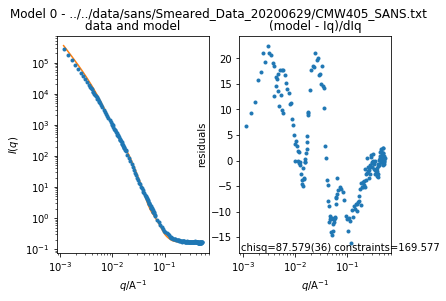

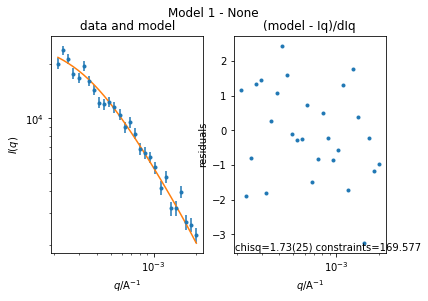

In [166]:
os.makedirs('../data/sans/Sample_Fitting/fitting_results/ps_ellipsoid_cylinder_lm/',exist_ok=True)

for key in [405]:#,31,403]:#404,405,408,504,505]:

    problem, result = fit_function2(key, sans_data, usans_data, actual_vol, actual_stdev_vol, backgrounds, avg_scale, avg_rg, ps_s, ps_porod_exp, slds, cps, matrix)
    #problem.plot()
#     all_problems[key] = (problem, result)

#     params = [str(key) + ' ellipsoid equatorial radius',str(key) + ' ellipsoid polar radius',str(key)+' cylinder length',str(key) + ' cylinder radius',str(key) + ' B scale ratio',str(key) + ' cp scale']
#     params = np.array(params)

#     print(result.x.astype(str))
#     save_results = result.x.astype(str)
#     save_results_dx = result.dx.astype(str)

#     np.savetxt('../../data/sans/Sample_Fitting/fitting_results/ps_ellipsoid_cylinder_lm/CMW' + str(key) + '_results.csv', np.vstack((params,save_results,save_results_dx)).T, delimiter=',', fmt='%s')
problem.plot()

In [168]:
params = [str(key) + ' ellipsoid equatorial radius',str(key) + ' ellipsoid polar radius',str(key)+' cylinder length',str(key) + ' cylinder radius',str(key) + ' B scale ratio',str(key) + ' cp scale']
params = np.array(params)

print(result.x.astype(str))
save_results = result.x.astype(str)
save_results_dx = result.dx.astype(str)

np.savetxt('../../data/sans/Sample_Fitting/fitting_results/ps_ellipsoid_cylinder_lm/CMW' + str(key) + '_results.csv', np.vstack((params,save_results,save_results_dx)).T, delimiter=',', fmt='%s')


['3350.307971404456' '227.54300642360207' '87512.82410969769'
 '70.31528355784859' '0.7515187108174703' '0.06161565347833629']


In [169]:
def fit_function2(
    key,
    sans_data,
    usans_data,
    actual_vol,
    actual_stdev_vol,
    backgrounds,
    avg_scale,
    avg_rg,
    ps_s,
    ps_porod_exp,
    slds,
    cps,
    matrix):

    #np.savetxt('Sample_'+str(key)+'.txt', np.array(['Fitting']), fmt='%s')
    kernel = load_model("guinier_porod+ellipsoid+cylinder")


    # loading the data
    sans = sans_data[key]
    sans.dx = sans.dx-sans.dx # removing smearing from sans segment
    usans = usans_data[key]
    
    mask = np.where(usans.x>2e-4)
    
    usans = sasmodels.data.Data1D(x=usans.x[mask],y=usans.y[mask],dx=usans.dx[mask],dy=usans.dy[mask])

    vol = actual_vol[key]/100 # cp volume fraction from uv-vis
    vol_stdev = actual_stdev_vol[key]/100

    # initial parameter values

    scale = Parameter(1, name=str(key) + 'scale')
    background = Parameter(backgrounds[key][0], name=str(key) + 'background')

    A_scale = Parameter(avg_scale*(1-vol), name=str(key) + ' PS scale')
    A_rg = Parameter(avg_rg, name=str(key) + ' PS rg')
    A_s = Parameter(ps_s, name=str(key) + ' PS s')
    A_porod_exp = Parameter(ps_porod_exp, name=str(key) + ' PS porod_exp')

    scale_ratio = Parameter(0.85, name=str(key) + ' B scale ratio').range(0,1)
    scale_normal = bumps.bounds.Normal(mean=vol, std=vol_stdev)
    cp_scale = Parameter(vol, name=str(key) + ' cp scale', bounds=scale_normal)
    
    B_scale = scale_ratio * cp_scale

    B_sld = Parameter(slds[cps[key]], name=str(key) + ' PS sld')
    B_sld_solvent = Parameter(slds[matrix[key]], name=str(key) + ' PS solvent')

    B_radius_polar = Parameter(250, limits=[0,inf], name=str(key) + ' ellipsoid polar radius').range(100,1000)
    B_radius_polar_pd = Parameter(0.5, name = str(key) + ' ellipsoid polar radius pd')
    B_radius_polar_pd_n = Parameter(200, name = str(key) + ' ellipsoid polar radius pd n')
    B_radius_polar_pd_nsigma = Parameter(8, name = str(key) + ' ellipsoid polar radius pd nsigma') 
    
    B_radius_equatorial = Parameter(2167, limits=[0,inf], name=str(key) + ' ellipsoid equatorial radius').range(1000,4000)
    B_radius_equatorial_pd = Parameter(0.5, name = str(key) + ' ellipsoid equatorial radius pd')
    B_radius_equatorial_pd_n = Parameter(200, name = str(key) + ' ellipsoid equatorial radius pd n')
    B_radius_equatorial_pd_nsigma = Parameter(8, name = str(key) + ' ellipsoid equatorial radius pd nsigma') 
    
    C_scale = (1-scale_ratio) * cp_scale
    
    C_sld = Parameter(slds[cps[key]], name=str(key) + ' PS sld')
    C_sld_solvent = Parameter(slds[matrix[key]], name=str(key) + ' PS solvent')
        
    C_radius = Parameter(72, limits=[0,inf], name = str(key) + ' cylinder radius').range(10,200)
    C_radius_pd  = Parameter(0.2, name = str(key) + ' cylinder radius pd')
    C_radius_pd_n = Parameter(200, name = str(key) + ' cylinder radius pd n')
    C_radius_pd_nsigma = Parameter(8, name = str(key) + ' cylinder radius pd nsigma')

    C_length = Parameter(104160, limits=[0,inf], name = str(key) + ' cylinder length').range(10000,300000)
    #C_length = Parameter(200000, limits=[0,inf], name = str(key) + ' length')
    C_length_pd  = Parameter(0, name = str(key) + ' length pd')
    C_length_pd_n = Parameter(200, name = str(key) + ' length pd n')
    C_length_pd_nsigma = Parameter(8, name = str(key) + ' length pd nsigma')
   

    # setting up the combined model for fitting
    sans_model = Model(
        model=kernel,
        scale=scale,
        background=background,
        A_scale=A_scale,
        A_rg=A_rg,
        A_s=A_s,
        A_porod_exp=A_porod_exp,
        B_scale=B_scale,
        B_sld=B_sld,
        B_sld_solvent=B_sld_solvent,
        B_radius_polar = B_radius_polar,
        B_radius_polar_pd_type = 'lognormal',
        B_radius_polar_pd = B_radius_polar_pd,
        B_radius_polar_pd_n = B_radius_polar_pd_n,
        B_radius_polar_pd_nsigma = B_radius_polar_pd_nsigma,
        B_radius_equatorial = B_radius_equatorial,
        B_radius_equatorial_pd_type = 'lognormal',
        B_radius_equatorial_pd = B_radius_equatorial_pd,
        B_radius_equatorial_pd_n = B_radius_equatorial_pd_n,
        B_radius_equatorial_pd_nsigma = B_radius_equatorial_pd_nsigma,
        C_scale = C_scale,
        C_sld = C_sld,
        C_sld_solvent = C_sld_solvent,
        C_radius = C_radius,
        C_radius_pd_type='lognormal',
        C_radius_pd = C_radius_pd,
        C_radius_pd_n = C_radius_pd_n,
        C_radius_pd_nsigma = C_radius_pd_nsigma,
        C_length = C_length,
        C_length_pd_type='lognormal',
        C_length_pd = C_length_pd,
        C_length_pd_n = C_length_pd_n,
        C_length_pd_nsigma = C_length_pd_nsigma,
    )

    # setting parameter ranges as needed

    sans_experiment=Experiment(data=sans, model=sans_model)
    usans_experiment=Experiment(data=usans, model=sans_model)

    usans_smearing = sasmodels.resolution.Slit1D(usans.x, 0.117)
    usans_experiment.resolution = usans_smearing

    experiment = [sans_experiment, usans_experiment]

    problem=FitProblem(experiment, weights=[0.1,0.9])
    
    result=fit(problem, method='lm', verbose=True)
    #result = None
    
    #result=fit(problem, method='dream', samples=1e6, verbose=True)
    #result.state.save('../data/sans/Sample_Fitting/fitting_results/ps_sphere_parrallelepiped/CMW' + str(key) + '_ps_sphere_parallelepiped_state')
    
    return(problem, result)


final chisq 82.376(32) constraints=348.035
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
         403 ellipsoid equatorial radius 2.81(30)e3      2.81(29)e3     
              403 ellipsoid polar radius 243.3(95)       243.3(92)      
                     403 cylinder length 87.5(41)e3      87.5(40)e3     
                     403 cylinder radius 68.0(18)        68.0(17)       
                       403 B scale ratio 0.679(15)       0.679(14)      
                            403 cp scale 0.01466(21)     0.01466(21)    


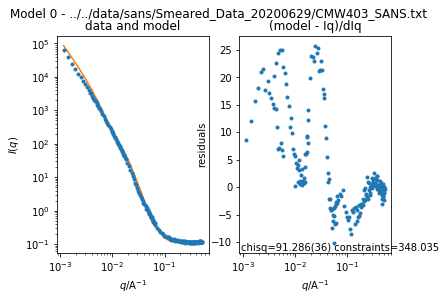

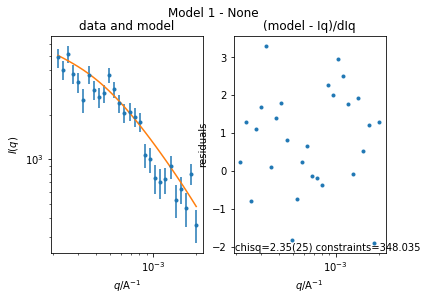

In [170]:
os.makedirs('../data/sans/Sample_Fitting/fitting_results/ps_ellipsoid_cylinder_lm/',exist_ok=True)

for key in [403]:#,31,403]:#404,405,408,504,505]:

    problem, result = fit_function2(key, sans_data, usans_data, actual_vol, actual_stdev_vol, backgrounds, avg_scale, avg_rg, ps_s, ps_porod_exp, slds, cps, matrix)
    #problem.plot()
#     all_problems[key] = (problem, result)

#     params = [str(key) + ' ellipsoid equatorial radius',str(key) + ' ellipsoid polar radius',str(key)+' cylinder length',str(key) + ' cylinder radius',str(key) + ' B scale ratio',str(key) + ' cp scale']
#     params = np.array(params)

#     print(result.x.astype(str))
#     save_results = result.x.astype(str)
#     save_results_dx = result.dx.astype(str)

#     np.savetxt('../../data/sans/Sample_Fitting/fitting_results/ps_ellipsoid_cylinder_lm/CMW' + str(key) + '_results.csv', np.vstack((params,save_results,save_results_dx)).T, delimiter=',', fmt='%s')
problem.plot()